In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facial-expression-recognitionferchallenge/Submission.csv
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/README
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.bib
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv


In [2]:
!pip install tensorflow
import tensorflow as tf

In [3]:
!pip install matplotlib

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [5]:
data = pd.read_csv("../input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv")
#check the number of images and each image data variable
data.shape
data.head()
np.unique(data["Usage"].values.ravel())
train_data = data[data.Usage == "Training"]
pixels_values = train_data.pixels.str.split(" ").tolist()
pixels_values = pd.DataFrame(pixels_values, dtype=int)
images = pixels_values.values
images = images.astype(np.float)

In [6]:
def show(img):
    show_image = img.reshape(48,48)
    plt.imshow(show_image, cmap='gray')

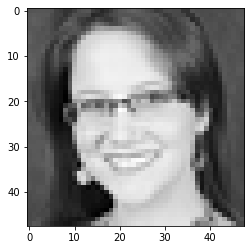

In [7]:
show(images[7])

In [8]:
images = images - images.mean(axis=1).reshape(-1,1)
images = np.multiply(images,100.0/255.0)
each_pixel_mean = images.mean(axis=0)
each_pixel_std = np.std(images, axis=0)
images = np.divide(np.subtract(images,each_pixel_mean), each_pixel_std)
image_pixels = images.shape[1]
print ('Flat pixel values is %d'%(image_pixels))
image_width = image_height = np.ceil(np.sqrt(image_pixels)).astype(np.uint8)
labels_flat = train_data["emotion"].values.ravel()
labels_count = np.unique(labels_flat).shape[0]

Flat pixel values is 2304


In [9]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot  
labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

In [10]:
VALIDATION_SIZE = 1709
validation_images = images[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]

train_images = images[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]

In [11]:
def weight_variable(shape):
    initial = tf.compat.v1.truncated_normal(shape, stddev=1e-4)
    return tf.Variable(initial)
def bias_variable(shape):
    initial = tf.compat.v1.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [12]:
def conv2d(x, W, padd):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding=padd)
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

In [13]:
tf.compat.v1.disable_eager_execution()

x = tf.compat.v1.placeholder(tf.float32, shape=(None, image_pixels))


In [14]:
y_ = tf.compat.v1.placeholder(tf.float32, shape=(None, labels_count))


In [15]:
W_conv1 = weight_variable([5, 5, 1, 64])
b_conv1 = bias_variable([64])
# (27000, 2304) => (27000,48,48,1)
image = tf.reshape(x, [-1,image_width , image_height,1])
#print (image.get_shape()) # =>(27000,48,48,1)
h_conv1 = tf.nn.relu(conv2d(image, W_conv1, "SAME") + b_conv1)
#print (h_conv1.get_shape()) # => (27000,48,48,64)
h_pool1 = max_pool_2x2(h_conv1)
#print (h_pool1.get_shape()) # => (27000,24,24,1)
h_norm1 = tf.nn.lrn(h_pool1, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)

In [16]:
W_conv2 = weight_variable([5, 5, 64, 128])
b_conv2 = bias_variable([128])
h_conv2 = tf.nn.relu(conv2d(h_norm1, W_conv2, "SAME") + b_conv2)
#print (h_conv2.get_shape()) # => (27000,24,24,128)
h_norm2 = tf.nn.lrn(h_conv2, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)
h_pool2 = max_pool_2x2(h_norm2)

In [17]:
def local_weight_variable(shape):
    initial = tf.compat.v1.truncated_normal(shape, stddev=0.04)
    return tf.Variable(initial)
def local_bias_variable(shape):
    initial = tf.compat.v1.constant(0.0, shape=shape)
    return tf.Variable(initial)

In [18]:
W_fc1 = local_weight_variable([12 * 12 * 128, 3072])
b_fc1 = local_bias_variable([3072])
# (27000, 12, 12, 128) => (27000, 12 * 12 * 128)
h_pool2_flat = tf.reshape(h_pool2, [-1, 12 * 12 * 128])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
#print (h_fc1.get_shape()) # => (27000, 1024)


In [19]:
W_fc2 = local_weight_variable([3072, 1536])
b_fc2 = local_bias_variable([1536])
# (40000, 7, 7, 64) => (40000, 3136)
h_fc2_flat = tf.reshape(h_fc1, [-1, 3072])
h_fc2 = tf.nn.relu(tf.matmul(h_fc2_flat, W_fc2) + b_fc2)
#print (h_fc1.get_shape()) # => (40000, 1024)

In [20]:
keep_prob = tf.compat.v1.placeholder('float')
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

In [21]:
W_fc3 = weight_variable([1536, labels_count])
b_fc3 = bias_variable([labels_count])
y = tf.nn.softmax(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)
#print (y.get_shape()) # => (40000, 10)

In [22]:
LEARNING_RATE = 1e-4

In [23]:
# cost function
cross_entropy = -tf.reduce_sum(y_*tf.compat.v1.log(y))
# optimisation function
train_step = tf.compat.v1.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)
# evaluation
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
# prediction function
#[0.1, 0.9, 0.2, 0.1, 0.1 0.3, 0.5, 0.1, 0.2, 0.3] => 1
predict = tf.argmax(y,1)

In [24]:
TRAINING_ITERATIONS = 3000
DROPOUT = 0.5
BATCH_SIZE = 50

In [25]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

# serve data by batches
def next_batch(batch_size):
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed 
    start = index_in_epoch
    index_in_epoch += batch_size    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

In [26]:
# start TensorFlow session
init =  tf.compat.v1.initialize_all_variables()
sess =  tf.compat.v1.InteractiveSession()
sess.run(init)
# visualisation variables
train_accuracies = []
validation_accuracies = []
x_range = []
display_step=1

In [27]:
for i in range(TRAINING_ITERATIONS):
    #get new batch
    batch_xs, batch_ys = next_batch(BATCH_SIZE)    
	# check progress on every 1st,2nd,...,10th,20th,...,100th... step
    if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, 
                                                  y_: batch_ys, 
                                                  keep_prob: 1.0})       
        if(VALIDATION_SIZE):
            validation_accuracy = accuracy.eval(feed_dict={ x: validation_images[0:BATCH_SIZE], 
                                                            y_: validation_labels[0:BATCH_SIZE], 
                                                            keep_prob: 1.0})                                  
            print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i))
            validation_accuracies.append(validation_accuracy)
            
        else:
             print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        # increase display_step
        if i%(display_step*10) == 0 and i and display_step<100:
            display_step *= 10
    # train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})

training_accuracy / validation_accuracy => 0.12 / 0.18 for step 0
training_accuracy / validation_accuracy => 0.12 / 0.18 for step 1
training_accuracy / validation_accuracy => 0.12 / 0.18 for step 2
training_accuracy / validation_accuracy => 0.10 / 0.18 for step 3
training_accuracy / validation_accuracy => 0.14 / 0.18 for step 4
training_accuracy / validation_accuracy => 0.14 / 0.18 for step 5
training_accuracy / validation_accuracy => 0.18 / 0.18 for step 6
training_accuracy / validation_accuracy => 0.18 / 0.18 for step 7
training_accuracy / validation_accuracy => 0.18 / 0.18 for step 8
training_accuracy / validation_accuracy => 0.18 / 0.18 for step 9
training_accuracy / validation_accuracy => 0.12 / 0.18 for step 10
training_accuracy / validation_accuracy => 0.10 / 0.18 for step 20
training_accuracy / validation_accuracy => 0.12 / 0.18 for step 30
training_accuracy / validation_accuracy => 0.04 / 0.18 for step 40
training_accuracy / validation_accuracy => 0.12 / 0.18 for step 50
train

In [28]:
import seaborn as sns

from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix

import itertools

validation_accuracy => 0.1556


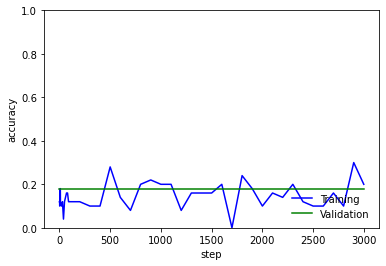

In [29]:
# check final accuracy on validation set  
if(VALIDATION_SIZE):
    validation_accuracy = accuracy.eval(feed_dict={x: validation_images, 
                                                   y_: validation_labels, 
                                                   keep_prob: 1.0})
    print('validation_accuracy => %.4f'%validation_accuracy)
    plt.plot(x_range, train_accuracies,'-b', label='Training')
    plt.plot(x_range, validation_accuracies,'-g', label='Validation')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.0, ymin = 0.0)
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.show()

In [30]:
saver = tf.compat.v1.train.Saver(tf.compat.v1.all_variables())
saver.save(sess, 'my-model1', global_step=0)
# read test data from CSV file 
test_data = data[data.Usage == "PublicTest"]
test_data.head()
len(test_data)
test_pixels_values = test_data.pixels.str.split(" ").tolist()
test_pixels_values = pd.DataFrame(test_pixels_values, dtype=int)
test_images = test_pixels_values.values
test_images = test_images.astype(np.float)
test_images = test_images - test_images.mean(axis=1).reshape(-1,1)
test_images = np.multiply(test_images,100.0/255.0)
test_images = np.divide(np.subtract(test_images,each_pixel_mean), each_pixel_std)

In [31]:
predicted_lables = np.zeros(test_images.shape[0])
for i in range(0,test_images.shape[0]//BATCH_SIZE):
    predicted_lables[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = predict.eval(feed_dict={x: test_images[i*BATCH_SIZE : (i+1)*BATCH_SIZE], 
                                                                                keep_prob: 1.0})


test_data.emotion.values
confusion_matrix(test_data.emotion.values, predicted_lables)

array([[467,   0,   0,   0,   0,   0,   0],
       [ 56,   0,   0,   0,   0,   0,   0],
       [496,   0,   0,   0,   0,   0,   0],
       [895,   0,   0,   0,   0,   0,   0],
       [653,   0,   0,   0,   0,   0,   0],
       [415,   0,   0,   0,   0,   0,   0],
       [607,   0,   0,   0,   0,   0,   0]])

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, int(cm[i, j]*100)/100.0,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')